In [1]:
from   astropy.table         import Table
import pylab                 as pl
import numpy                 as np
import pandas                as pd
import os
from   astropy.io            import fits
from   glob                  import glob
from   desitarget.targetmask import desi_mask, bgs_mask, mws_mask
from   scipy.spatial         import KDTree

In [2]:
params = {'legend.fontsize': '20',
          'figure.figsize': (10, 10),
         'axes.labelsize': '20',
         'axes.titlesize':'20',
         'xtick.labelsize':'20',
         'ytick.labelsize':'20',
         'axes.labelpad' : '20'}
pl.rcParams.update(params)

In [3]:
data = Table.read('../../data/gama_gold_ddp.fits')

In [4]:
# data.keys()

In [5]:
ra_gama   = data['RA']
dec_gama  = data['DEC']
z_gama    = data['ZGAMA']

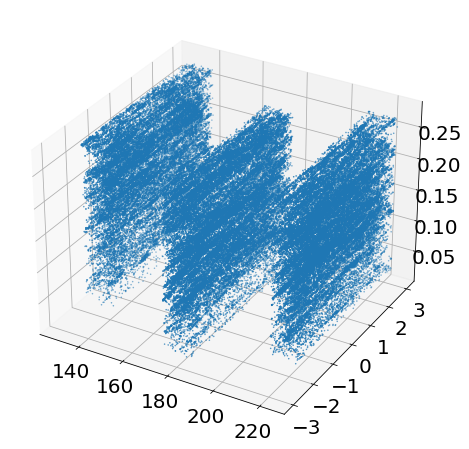

In [6]:
# Plot ra dec redshift
fig = pl.figure(figsize=(8,8))
ax = pl.axes(projection='3d')
ax.scatter(ra_gama, dec_gama, z_gama, s=0.3)
pl.show()

In [7]:
# load the DES bright (BGS galaxies)
flavour = 'bright'
if flavour == 'bright':
    df_des = pd.read_csv('./data/DR9_BGSBRIGHT_data.csv')
else:
    df_des = pd.read_csv('./data/DR9_LRG_data.csv')

In [8]:
# df_des

In [9]:
ra_des  = df_des['RA']
dec_des = df_des['DEC']

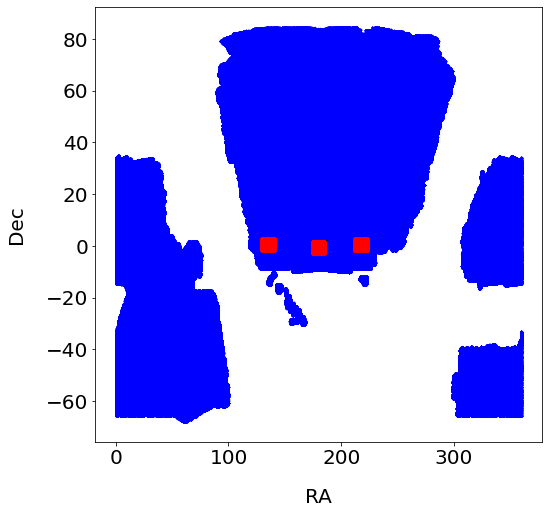

In [10]:
# Plot the GAMA region in the DES catalog
fig = pl.figure(figsize=(8,8))
pl.scatter(ra_des,  dec_des,  s=0.3, c='b')
pl.scatter(ra_gama, dec_gama, s=0.3, c='r')
pl.xlabel('RA')
pl.ylabel('Dec')
pl.show()

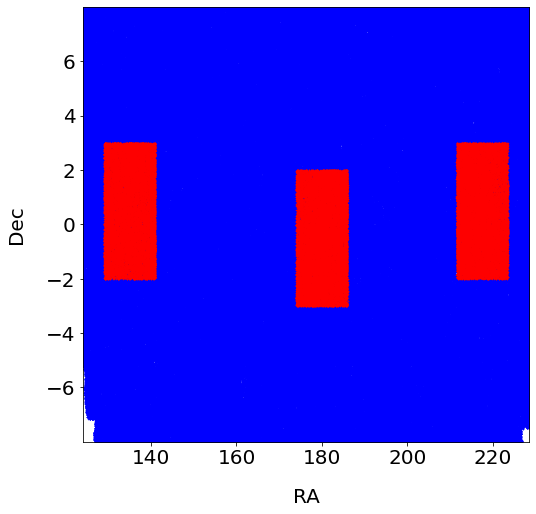

In [11]:
# RA Dec Match zoom in
fig = pl.figure(figsize=(8,8))
pl.scatter(ra_des,  dec_des,  s=0.3, c='b')
pl.scatter(ra_gama, dec_gama, s=0.3, c='r')
pl.xlim(min(ra_gama)-5,max(ra_gama)+5)
pl.ylim(min(dec_gama)-5,max(dec_gama)+5)
pl.xlabel('RA')
pl.ylabel('Dec')
pl.show()

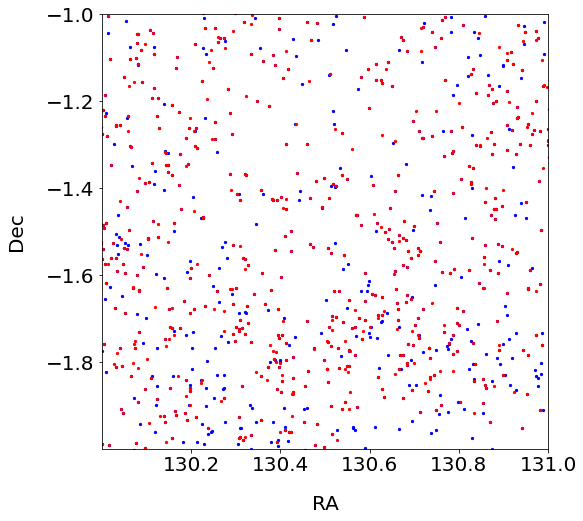

In [12]:
# RA Dec Match zoom in more
fig = pl.figure(figsize=(8,8))
pl.scatter(np.around(ra_des,  3), np.around(dec_des,  3), s=5, c='b')
pl.scatter(np.around(ra_gama, 3), np.around(dec_gama, 3), s=5, c='r')
pl.xlim(min(ra_gama)+1,min(ra_gama)+2)
pl.ylim(min(dec_gama)+1,min(dec_gama)+2)
pl.xlabel('RA')
pl.ylabel('Dec')
pl.show()

In [13]:
# Load trees for des data
tree = KDTree(np.c_[ra_des, dec_des])

In [14]:
# Find the 1-NN for each GAMA RA Dec
distances, indices = tree.query(np.c_[ra_gama, dec_gama], k=1)

In [15]:
len(indices), len(ra_gama)

(121975, 121975)

Text(0.5, 0, 'Distance [Mpc]')

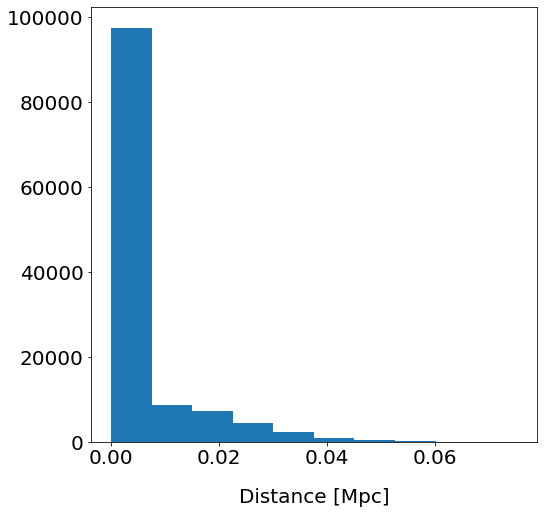

In [16]:
fig = pl.figure(figsize=(8,8))
_ = pl.hist(distances)
pl.xlabel('Distance [Mpc]')

In [17]:
np.shape(indices), indices[0]

((121975,), 8259360)

In [18]:
# Ordening the DES entries using the IDs get for indices
df_des.iloc[indices]

,ID,RA,DEC,TARGETID,E1,E2,E,R,BA,PHI
8259360,8259360.0,138.241044,1.389790,3.962782e+16,-0.118534,-0.144397,0.186818,1.579568,0.685179,-1.129072
8048618,8048618.0,175.447698,0.101483,3.962779e+16,-0.183436,0.181817,0.258276,1.227511,0.589476,1.180313
7508779,7508779.0,215.743360,0.113722,3.962779e+16,0.192794,0.274709,0.335611,0.831682,0.497442,0.479428
7513186,7513186.0,217.206162,0.625468,3.962781e+16,0.276277,0.107599,0.296491,2.547027,0.542626,0.185693
6863995,6863995.0,133.786342,-0.477461,3.962777e+16,0.321978,0.295408,0.436962,1.637032,0.391825,0.371194
...,...,...,...,...,...,...,...,...,...,...
7491850,7491850.0,220.540384,0.440204,3.962780e+16,-0.004174,0.023976,0.024337,1.300240,0.952483,0.871580
7510144,7510144.0,216.369711,0.175900,3.962779e+16,0.643041,0.255638,0.691992,2.672667,0.182039,0.189194
12306559,12306559.0,137.391454,2.571390,3.962785e+16,0.009154,-0.006745,0.011371,1.771071,0.977513,-0.317510
7591914,7591914.0,212.393110,1.437418,3.962782e+16,-0.248450,-0.348727,0.428180,1.257258,0.400384,-1.094914


In [19]:
# df_match = pd.DataFrame( df_des.iloc[indices], data )
# df_match

In [20]:
len(data), len(df_des.iloc[indices])

(121975, 121975)

In [21]:
data_match = data.copy()

In [22]:
df_des.keys()

Index(['ID', 'RA', 'DEC', 'TARGETID', 'E1', 'E2', 'E', 'R', 'BA', 'PHI'], dtype='object')

In [23]:
# Match GAMA and DES
data_match['RA_DES']              = df_des['RA'].iloc[indices]
data_match['DEC_DES']             = df_des['DEC'].iloc[indices]
data_match['TARGETID_DES']        = np.array(df_des['TARGETID'].iloc[indices], dtype=int)
data_match['E1_DES']              = df_des['E1'].iloc[indices]
data_match['E2_DES']              = df_des['E2'].iloc[indices]
data_match['E_DES']               = df_des['E'].iloc[indices]
data_match['R_DES']               = df_des['R'].iloc[indices]
data_match['BA_DES']              = df_des['BA'].iloc[indices]
data_match['PHI_DES']             = df_des['PHI'].iloc[indices]
data_match['DISTANCE_MATCH_DES']  = distances

In [24]:
data_match.keys()

['CATAID',
 'OBJID',
 'RA',
 'DEC',
 'R_PETRO',
 'ZGAMA',
 'NQ',
 'SPECID',
 'SURVEY_CLASS',
 'UMAG_DRED_SDSS',
 'GMAG_DRED_SDSS',
 'RMAG_DRED_SDSS',
 'IMAG_DRED_SDSS',
 'ZMAG_DRED_SDSS',
 'ZSURV',
 'LUMDIST',
 'DISTMOD',
 'FIELD',
 'IN_D8LUMFN',
 'CONSERVATIVE',
 'CARTESIAN_X',
 'CARTESIAN_Y',
 'CARTESIAN_Z',
 'ROTCARTESIAN_X',
 'ROTCARTESIAN_Y',
 'ROTCARTESIAN_Z',
 'GMR',
 'DETMAG',
 'REST_GMR_0P1',
 'REST_GMR_0P1_WARN',
 'REST_GMR_0P1_INDEX',
 'KCORR_R0P1',
 'KCORR_G0P1',
 'KCORR_R0P0',
 'KCORR_G0P0',
 'REST_GMR_0P0',
 'Q_COLOR_0P0',
 'EQ_ALL_0P0',
 'EQ_COLOR_0P0',
 'MALL_0P0',
 'MCOLOR_0P0',
 'MQZERO_0P0',
 'Z_THETA_QALL',
 'Z_THETA_QZERO',
 'Z_THETA_QCOLOR',
 'DDPKCORR_R0P1',
 'DDPKCORR_G0P1',
 'DDPKCORR_R0P0',
 'DDPKCORR_G0P0',
 'DDPMALL_0P0',
 'DELTA_DETMAG_FAINT',
 'ZMAX',
 'ZMAX_WARN',
 'DELTA_DETMAG_BRIGHT',
 'ZMIN',
 'ZMIN_WARN',
 'VMAX',
 'DDP',
 'DDPZLIMS',
 'STEPWISE_FAINTLIM_0P0',
 'STEPWISE_BRIGHTLIM_0P0',
 'RA_DES',
 'DEC_DES',
 'TARGETID_DES',
 'E1_DES',
 'E2_DES',
 '

In [25]:
data_match.write('./data/gamades_gold_ddp.fits', overwrite=True)

In [26]:
data_match.info

<Table length=121975>
         name           dtype  shape unit    class     n_bad
---------------------- ------- ----- ---- ------------ -----
                CATAID   int32            MaskedColumn     0
                 OBJID   int64            MaskedColumn     0
                    RA float64        deg       Column     0
                   DEC float64        deg       Column     0
               R_PETRO float32        mag       Column     0
                 ZGAMA float32                  Column     0
                    NQ   int16            MaskedColumn     0
                SPECID bytes33                  Column     0
          SURVEY_CLASS   int16            MaskedColumn     0
        UMAG_DRED_SDSS float32        mag       Column     0
        GMAG_DRED_SDSS float32        mag       Column     0
        RMAG_DRED_SDSS float32        mag       Column     0
        IMAG_DRED_SDSS float32        mag       Column     0
        ZMAG_DRED_SDSS float32        mag       Column     0
  

In [27]:
# Filter for ddp1
ii_ddp1 = data_match['DDP'][:,0] == 1
sum(ii_ddp1), len(ii_ddp1)

(50872, 121975)

In [28]:
# Filter the match using a distance less than 0.0001 
ii_distance = data_match['DISTANCE_MATCH_DES'] < 0.0001
sum(ii_distance)

88976

In [29]:
# Finally data lenght for ddp1 and minimal distance match with NN
len(data_match['RA'][ii_ddp1 & ii_distance])

43446

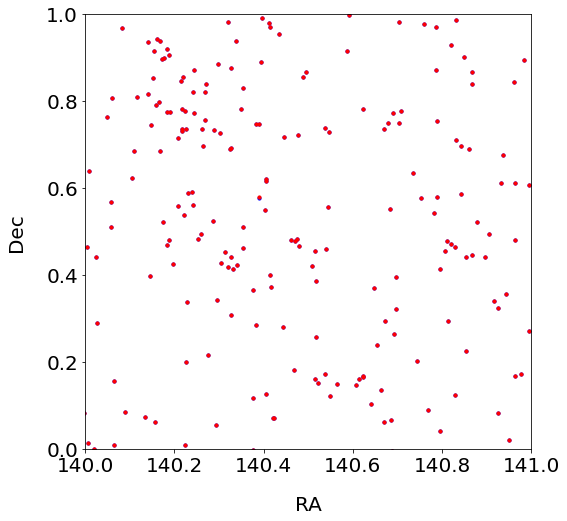

In [30]:
# Apply the filters iiddp1 and ii_distance
fig = pl.figure(figsize=(8,8))
pl.scatter( data_match['RA'][ii_ddp1 & ii_distance], data_match['DEC'][ii_ddp1 & ii_distance], s=10, c='b' )
pl.scatter( data_match['RA_DES'][ii_ddp1 & ii_distance], data_match['DEC_DES'][ii_ddp1 & ii_distance], s=10, c='r')
pl.xlim(140,141)
pl.ylim(0,1)
pl.xlabel('RA')
pl.ylabel('Dec')
pl.show()

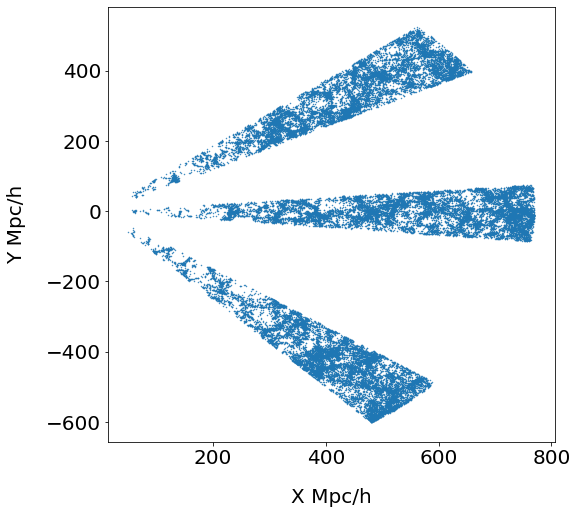

In [31]:
fig = pl.figure(figsize=(8,8))
pl.scatter( data_match['ROTCARTESIAN_X'][ii_ddp1 & ii_distance], data_match['ROTCARTESIAN_Y'][ii_ddp1 & ii_distance], s=0.2 )
pl.xlabel('X Mpc/h')
pl.ylabel('Y Mpc/h')
pl.show()

### G15

In [32]:
ii_g15 = data_match['FIELD'] == 'G15'
sum(ii_g15)

41178

In [33]:
# Number of points in G15 for DDP1 matched with DES
len(data_match['RA'][ii_ddp1 & ii_distance & ii_g15])

13917

In [34]:
idx = np.arange(0,sum( ii_ddp1 & ii_distance & ii_g15 ))
idx

array([    0,     1,     2, ..., 13914, 13915, 13916])

In [35]:
xyz_labels = ['ROTCARTESIAN_X','ROTCARTESIAN_Y','ROTCARTESIAN_Z']
df_pos = data[xyz_labels].to_pandas()
df_pos = df_pos[ii_ddp1 & ii_distance & ii_g15]
df_pos

,ROTCARTESIAN_X,ROTCARTESIAN_Y,ROTCARTESIAN_Z
10,376.361051,259.703020,-14.427125
24,609.593909,452.947333,-16.324600
31,405.860384,283.908626,4.539176
53,467.229273,373.702543,-10.689510
63,481.288111,325.743350,10.289737
...,...,...,...
121905,407.589286,340.443790,-12.238181
121914,315.898864,247.876021,-13.606974
121929,276.450757,210.851126,0.188152
121933,358.783727,226.700636,8.862379


In [36]:
np.savetxt('./data/GAMADES_pos_ddp1_g15.txt', np.c_[np.arange(len(df_pos.values)), df_pos.values] , fmt='%d', header='id px py pz')

In [37]:
f = open('./data/GAMADES_pos_ddp1_g15.txt.NDnet_s3.5.up.NDskl.S010.a.NDskl')
doc = f.readlines()

In [38]:
# Number of filaments from Disperse
doc = np.array(doc)
ii = np.where(doc=='[FILAMENTS]\n')[0][0]
N_fila = int(doc[ii+1])
N_fila

324

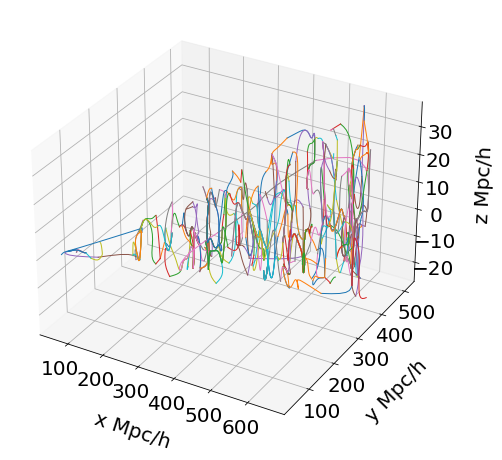

In [39]:
FILA = np.zeros(N_fila, dtype=object)
jj = ii+2
jj_new = 0
# print(doc[jj][0].replace('\n','').split(' ')[2])
fig = pl.figure(figsize=(8,8), rasterized=True)
ax = pl.axes(projection='3d')
ax.set_xlabel('x Mpc/h')
ax.set_ylabel('y Mpc/h')
ax.set_zlabel('z Mpc/h')
for i in range(N_fila):
    jj_new = jj + int(doc[jj].replace('\n','').split(' ')[2]) + 1
    FILA[i] = np.array([a.replace('\n','').split(' ')[1:] for a in doc[jj+1:jj_new]], dtype=float)
    # print(jj,jj_new)
    # print(doc[jj].replace('\n',''),doc[jj_new])
    ax.plot3D(FILA[i][:,0], FILA[i][:,1], FILA[i][:,2], lw=1) 
    jj = jj_new

pl.savefig('./figs/GAMADES_ddp1_g15.pdf', bbox_inches='tight')
pl.show()

In [153]:
sum(ii_ddp1 & ii_distance & ii_g15), sum(ii_ddp1 & ii_g15)

(13917, 16318)

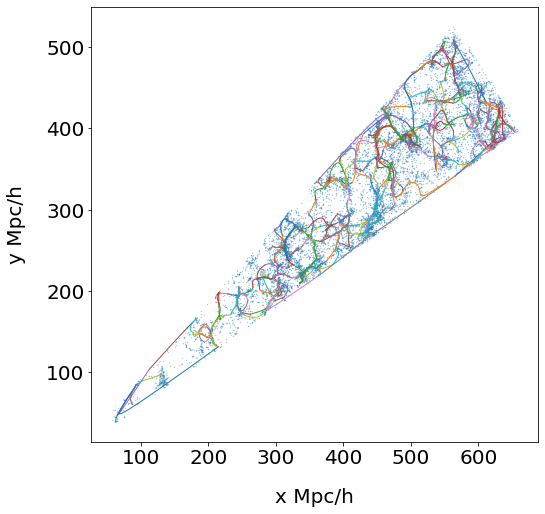

In [40]:
fig = pl.figure(figsize=(8,8), rasterized=True)
pl.scatter( data_match['ROTCARTESIAN_X'][ii_ddp1 & ii_distance & ii_g15], data_match['ROTCARTESIAN_Y'][ii_ddp1 & ii_distance & ii_g15], s=0.1, alpha=0.5 )
jj = ii+2
jj_new = 0
fila_x = []
fila_y = []
fila_z = []
for i in range(N_fila):
    jj_new = jj + int(doc[jj].replace('\n','').split(' ')[2]) + 1
    FILA[i] = np.array([a.replace('\n','').split(' ')[1:] for a in doc[jj+1:jj_new]], dtype=float)
    fila_x.append( FILA[i][:,0] ) 
    fila_y.append( FILA[i][:,1] ) 
    fila_z.append( FILA[i][:,2] ) 
    # print(jj,jj_new)
    # print(doc[jj].replace('\n',''),doc[jj_new])
    pl.plot(FILA[i][:,0], FILA[i][:,1], lw=1) 
    jj = jj_new
pl.xlabel('x Mpc/h')
pl.ylabel('y Mpc/h')
pl.show()

In [41]:
#Lenght of each filament
LEN_FILA = np.array([len(i) for i in FILA])
# LEN_FILA

## Finding the nearest Filament

In [42]:
def get_ID_FILA(pos,L):
    total = 0
    for i,l in enumerate(L):
        total += l
        if pos < total:
            return i

def get_distance(x1,y1,z1,x2,y2,z2):
    return np.sqrt( (x1-x2)**2 +(y1-y2)**2 +(z1-z2)**2   )

In [43]:
# Extend all the filaments
fila_x_arr = np.concatenate(fila_x).ravel()
fila_y_arr = np.concatenate(fila_y).ravel()
fila_z_arr = np.concatenate(fila_z).ravel()
len(fila_x_arr)

7529

In [45]:
# Find the nearest filament point to each galaxy
tree_fila = KDTree(np.c_[fila_x_arr, fila_y_arr, fila_z_arr])
distances_fila, indices_fila = tree_fila.query(np.c_[df_pos], k=1)

In [46]:
ID_FILA = np.zeros(len(indices_fila), dtype=int)
ID_FILA_NEXT = np.zeros(len(indices_fila), dtype=int)
ID_FILA_LAST = np.zeros(len(indices_fila), dtype=int)
ID_FILA_SEGMENTS = np.zeros(len(indices_fila), dtype=object)
for i, index in enumerate(indices_fila):
    ID_FILA[i] = get_ID_FILA(index, LEN_FILA)
    ID_FILA_NEXT[i] = get_ID_FILA(index+1, LEN_FILA)
    ID_FILA_LAST[i] = get_ID_FILA(index-1, LEN_FILA)
    
    if (get_ID_FILA(index, LEN_FILA) == get_ID_FILA(index+1, LEN_FILA)) & (get_ID_FILA(index, LEN_FILA) != get_ID_FILA(index-1, LEN_FILA)):
        ID_FILA_SEGMENTS[i] = np.array([index,index+1])
    elif (get_ID_FILA(index, LEN_FILA) != get_ID_FILA(index+1, LEN_FILA)) & (get_ID_FILA(index, LEN_FILA) == get_ID_FILA(index-1, LEN_FILA)):
        ID_FILA_SEGMENTS[i] = np.array([index,index-1])
    elif (get_ID_FILA(index, LEN_FILA) == get_ID_FILA(index+1, LEN_FILA)) & (get_ID_FILA(index, LEN_FILA) == get_ID_FILA(index-1, LEN_FILA)):
        d_next = get_distance(fila_x_arr[index],fila_y_arr[index],fila_z_arr[index],fila_x_arr[index+1],fila_y_arr[index+1],fila_z_arr[index+1])
        d_last = get_distance(fila_x_arr[index],fila_y_arr[index],fila_z_arr[index],fila_x_arr[index-1],fila_y_arr[index-1],fila_z_arr[index-1])
        if d_next < d_last:
            ID_FILA_SEGMENTS[i] = np.array([index,index+1])
        elif d_next >= d_last:
            ID_FILA_SEGMENTS[i] = np.array([index,index-1])

In [47]:
ID_FILA_SEGMENTS

array([array([4995, 4996]), array([6360, 6359]), array([5251, 5252]), ...,
       array([3653, 3652]), array([4165, 4166]), array([4831, 4832])],
      dtype=object)

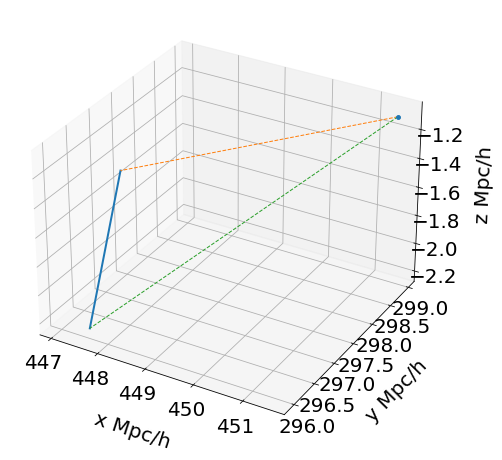

In [48]:
# ll = 2
fig = pl.figure(figsize=(8,8), rasterized=True)
ax = pl.axes(projection='3d')
ax.set_xlabel('x Mpc/h')
ax.set_ylabel('y Mpc/h')
ax.set_zlabel('z Mpc/h')
for N in [10]:
    ax.scatter3D(np.array(df_pos['ROTCARTESIAN_X'])[N],
                 np.array(df_pos['ROTCARTESIAN_Y'])[N],
                 np.array(df_pos['ROTCARTESIAN_Z'])[N], s=15)
    
    ax.plot3D(fila_x_arr[ID_FILA_SEGMENTS[N]],
              fila_y_arr[ID_FILA_SEGMENTS[N]],
              fila_z_arr[ID_FILA_SEGMENTS[N]], lw=2)
    
    ax.plot3D([np.array(df_pos['ROTCARTESIAN_X'])[N], fila_x_arr[ID_FILA_SEGMENTS[N]][0]],
              [np.array(df_pos['ROTCARTESIAN_Y'])[N], fila_y_arr[ID_FILA_SEGMENTS[N]][0]],
              [np.array(df_pos['ROTCARTESIAN_Z'])[N], fila_z_arr[ID_FILA_SEGMENTS[N]][0]], '--', lw=1)
    
    ax.plot3D([np.array(df_pos['ROTCARTESIAN_X'])[N], fila_x_arr[ID_FILA_SEGMENTS[N]][1]],
              [np.array(df_pos['ROTCARTESIAN_Y'])[N], fila_y_arr[ID_FILA_SEGMENTS[N]][1]],
              [np.array(df_pos['ROTCARTESIAN_Z'])[N], fila_z_arr[ID_FILA_SEGMENTS[N]][1]], '--', lw=1)


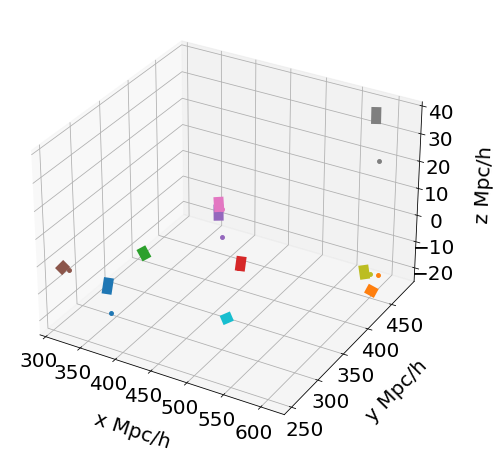

In [49]:
# ll = 2
fig = pl.figure(figsize=(8,8), rasterized=True)
ax = pl.axes(projection='3d')
ax.set_xlabel('x Mpc/h')
ax.set_ylabel('y Mpc/h')
ax.set_zlabel('z Mpc/h')
for N in np.arange(10):
    ax.scatter3D(np.array(df_pos['ROTCARTESIAN_X'])[N],
                 np.array(df_pos['ROTCARTESIAN_Y'])[N],
                 np.array(df_pos['ROTCARTESIAN_Z'])[N], s=15)
    
    ax.plot3D(fila_x_arr[ID_FILA_SEGMENTS[N]],
              fila_y_arr[ID_FILA_SEGMENTS[N]],
              fila_z_arr[ID_FILA_SEGMENTS[N]], lw=10)
    
#     ax.plot3D([np.array(df_pos['ROTCARTESIAN_X'])[N], fila_x_arr[ID_FILA_SEGMENTS[N]][0]],
#               [np.array(df_pos['ROTCARTESIAN_Y'])[N], fila_y_arr[ID_FILA_SEGMENTS[N]][0]],
#               [np.array(df_pos['ROTCARTESIAN_Z'])[N], fila_z_arr[ID_FILA_SEGMENTS[N]][0]], '--', lw=1)
    
#     ax.plot3D([np.array(df_pos['ROTCARTESIAN_X'])[N], fila_x_arr[ID_FILA_SEGMENTS[N]][1]],
#               [np.array(df_pos['ROTCARTESIAN_Y'])[N], fila_y_arr[ID_FILA_SEGMENTS[N]][1]],
#               [np.array(df_pos['ROTCARTESIAN_Z'])[N], fila_z_arr[ID_FILA_SEGMENTS[N]][1]], '--', lw=1)


In [50]:
# df_filaments = pd.DataFrame()
# df_filaments['FILAMENTS'] = FILA    #Save the filaments
# df_filaments['LEN_FILA'] = LEN_FILA # Save the number of point of each filament
# df_filaments['ID_FILA_SEGMENT'] = ID_FILA_SEGMENTS # Save the ids of the nearest filament segments by galaxy

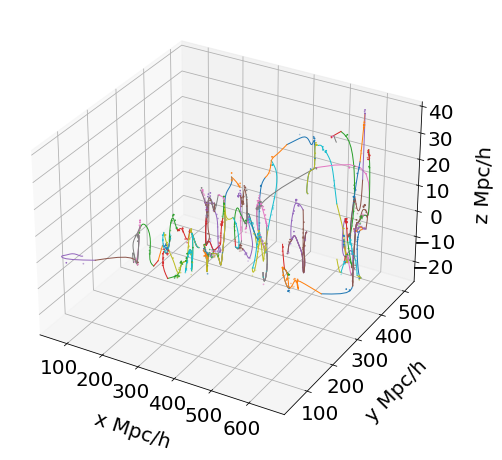

In [51]:
Ns = np.arange(100)
fig = pl.figure(figsize=(8,8))
ax = pl.axes(projection='3d')
ax.set_xlabel('x Mpc/h')
ax.set_ylabel('y Mpc/h')
ax.set_zlabel('z Mpc/h')

min_dis_fil = 2

for N in Ns:
    ii_fila = ID_FILA == N
    ii_fila_distance = distances_fila[ii_fila] < min_dis_fil
    # print(sum(ii_fila_distance))

    ax.scatter3D(data_match[ii_ddp1 & ii_g15 & ii_distance]['ROTCARTESIAN_X'][ii_fila][ii_fila_distance],
                 data_match[ii_ddp1 & ii_g15 & ii_distance]['ROTCARTESIAN_Y'][ii_fila][ii_fila_distance],
                 data_match[ii_ddp1 & ii_g15 & ii_distance]['ROTCARTESIAN_Z'][ii_fila][ii_fila_distance], s=0.5)
    ax.plot3D(FILA[N][:,0], FILA[N][:,1], FILA[N][:,2], lw=1)

Text(0, 0.5, 'y Mpc/h')

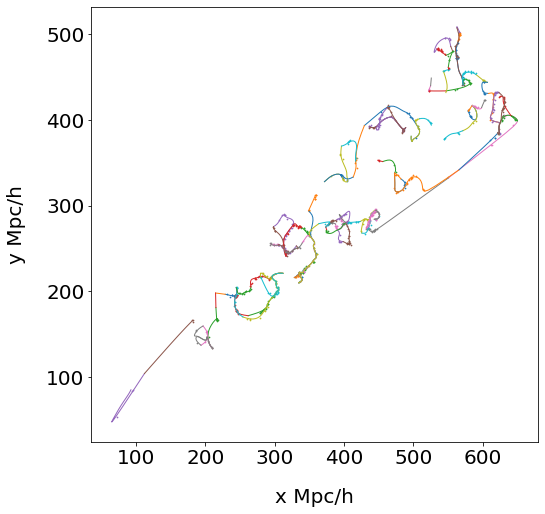

In [53]:
Ns = np.arange(100)
fig = pl.figure(figsize=(8,8))

for N in Ns:
    ii_fila = ID_FILA == N
    ii_fila_distance = distances_fila[ii_fila] < min_dis_fil
    # print(sum(ii_fila_distance))

    pl.scatter(data_match[ii_ddp1 & ii_g15 & ii_distance]['ROTCARTESIAN_X'][ii_fila][ii_fila_distance],
                 data_match[ii_ddp1 & ii_g15 & ii_distance]['ROTCARTESIAN_Y'][ii_fila][ii_fila_distance], s=0.5)
    pl.plot(FILA[N][:,0], FILA[N][:,1], lw=1)
pl.xlabel('x Mpc/h')
pl.ylabel('y Mpc/h')

Text(0.5, 0, 'Number of galaxies by filament \n distance< 2 Mpc/h')

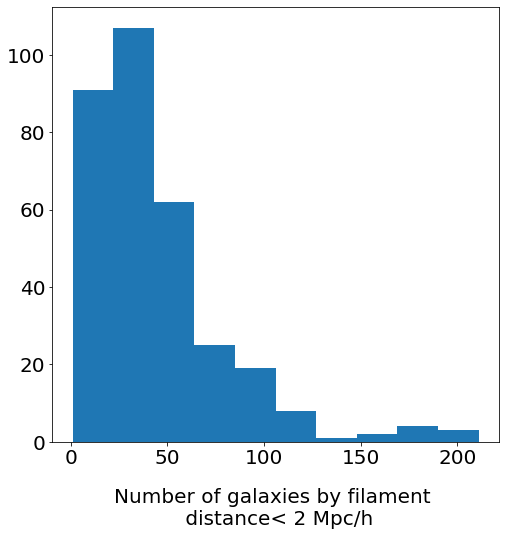

In [54]:
fig = pl.figure(figsize=(8,8))
_, counts = np.unique(ID_FILA, return_counts=True)
pl.hist(counts)
pl.xlabel(f'Number of galaxies by filament \n distance< {min_dis_fil} Mpc/h') # Number of points by filament with a minimal distance of min_dist to filament

## Computing the tilt of the Segments

In [55]:
from astropy.coordinates import SkyCoord

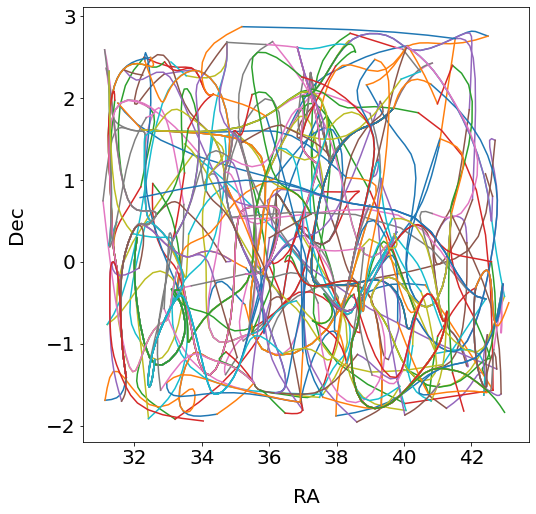

In [56]:
# Projection of the filaments in the RADEC space
Ns = np.arange(1)
fig = pl.figure(figsize=(8,8))

for fil in FILA:
    # print(sum(ii_fila_distance))    
    c = SkyCoord(x=fil[:,0], y=fil[:,1], z=fil[:,2], unit='Mpc/h', representation_type='cartesian')
    c.representation_type = 'spherical'
    pl.plot(c.to_table()['ra'], c.to_table()['dec'])
    
pl.xlabel('RA')
pl.ylabel('Dec')
pl.show()

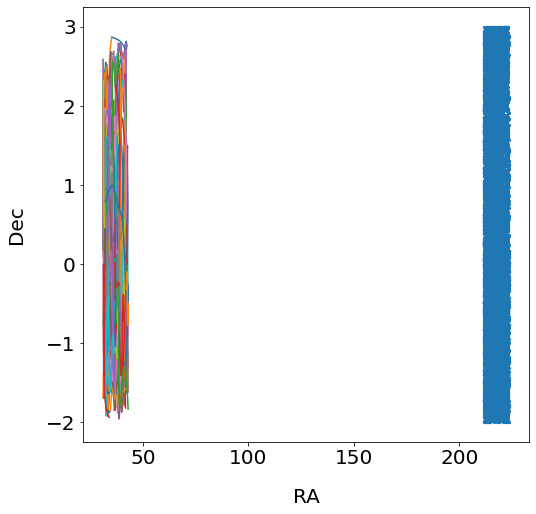

In [57]:
# Filaments and galaxies projected in RADEC
fig = pl.figure(figsize=(8,8))

for fil in FILA:
    # print(sum(ii_fila_distance))    
    c = SkyCoord(x=fil[:,0], y=fil[:,1], z=fil[:,2], unit='Mpc/h', representation_type='cartesian')
    c.representation_type = 'spherical'
    pl.plot(c.to_table()['ra'], c.to_table()['dec'])
    
pl.scatter(data_match[ii_ddp1 & ii_g15 & ii_distance]['RA'],
           data_match[ii_ddp1 & ii_g15 & ii_distance]['DEC'], s=5)
pl.xlabel('RA')
pl.ylabel('Dec')
pl.show()

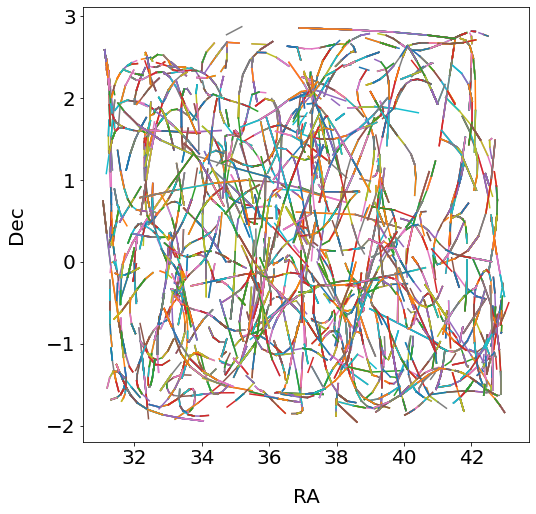

In [68]:
# Filaments and galaxies projected in RADEC
fig = pl.figure(figsize=(8,8))

c = SkyCoord(x=fila_x_arr, y=fila_y_arr, z=fila_z_arr, unit='Mpc/h', representation_type='cartesian')
c.representation_type = 'spherical'

for ifs in ID_FILA_SEGMENTS:

    pl.plot([c.to_table()[ 'ra'][ifs[0]].to_value(), c.to_table()[ 'ra'][ifs[1]].to_value()],
            [c.to_table()['dec'][ifs[0]].to_value(), c.to_table()['dec'][ifs[1]].to_value()])
    
# pl.scatter(data_match[ii_ddp1 & ii_g15 & ii_distance]['RA'],
#            data_match[ii_ddp1 & ii_g15 & ii_distance]['DEC'], s=5)
pl.xlabel('RA')
pl.ylabel('Dec')
pl.show()

In [137]:
# Compute the tilt of the segments
TILT_FILA_SEGMENTS_XY = np.zeros(len(df_pos))
TILT_FILA_SEGMENTS_RADEC = np.zeros(len(df_pos))

c0 = SkyCoord(x=fila_x_arr, y=fila_y_arr, z=fila_z_arr, unit='Mpc/h', representation_type='cartesian')

c0.representation_type = 'spherical'
for i in range(len(TILT_FILA_SEGMENTS_XY)):    
    
    TILT_FILA_SEGMENTS_XY[i] = np.arctan((fila_y_arr[ID_FILA_SEGMENTS[i]][0] - fila_y_arr[ID_FILA_SEGMENTS[i]][1])/
                                         (fila_x_arr[ID_FILA_SEGMENTS[i]][0] - fila_x_arr[ID_FILA_SEGMENTS[i]][1]) )
    
    
    TILT_FILA_SEGMENTS_RADEC[i] = np.arctan2((c0.to_table()['dec'][ID_FILA_SEGMENTS[i][1]]-c0.to_table()['dec'][ID_FILA_SEGMENTS[i][0]]).to_value(),
                                             (c0.to_table()['ra' ][ID_FILA_SEGMENTS[i][1]]-c0.to_table()['ra' ][ID_FILA_SEGMENTS[i][0]]).to_value())

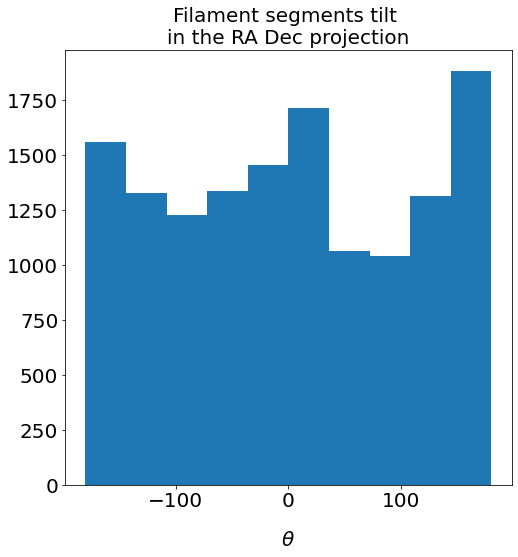

In [151]:
fig = pl.figure(figsize=(8,8))
_ = pl.hist(TILT_FILA_SEGMENTS_RADEC*180/np.pi)
len(TILT_FILA_SEGMENTS_RADEC)
pl.title('Filament segments tilt \nin the RA Dec projection')
pl.xlabel(r'$\theta$')
pl.show()

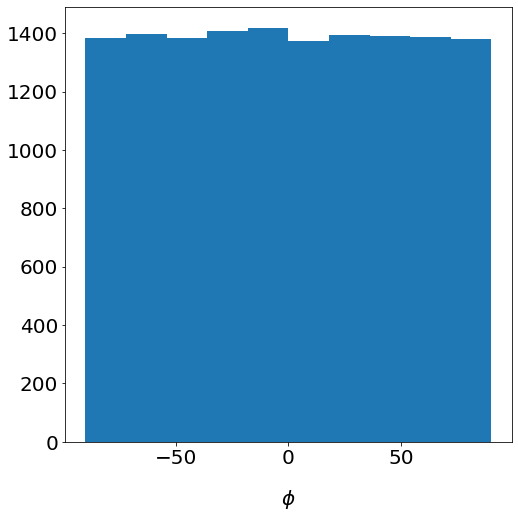

In [139]:
fig = pl.figure(figsize=(8,8))
_ = pl.hist(data_match['PHI_DES'][ii_ddp1 & ii_distance & ii_g15]*180/np.pi)
len(data_match[ii_ddp1 & ii_distance & ii_g15])
pl.xlabel(r'$\phi$')
pl.show()

In [140]:
df_tilt = pd.DataFrame()
df_tilt['FILAMENT_TILT'] = TILT_FILA_SEGMENTS_RADEC*90/np.pi
df_tilt['GALAXY_TILT']   = data_match['PHI_DES'][ii_ddp1 & ii_distance & ii_g15]*180/np.pi

In [141]:
# import seaborn as sns

In [142]:
# sns.pairplot(df_tilt, plot_kws={"s": 0.5})
# sns.set(rc={'figure.figsize':(15,15), 'marker_size':0.2})

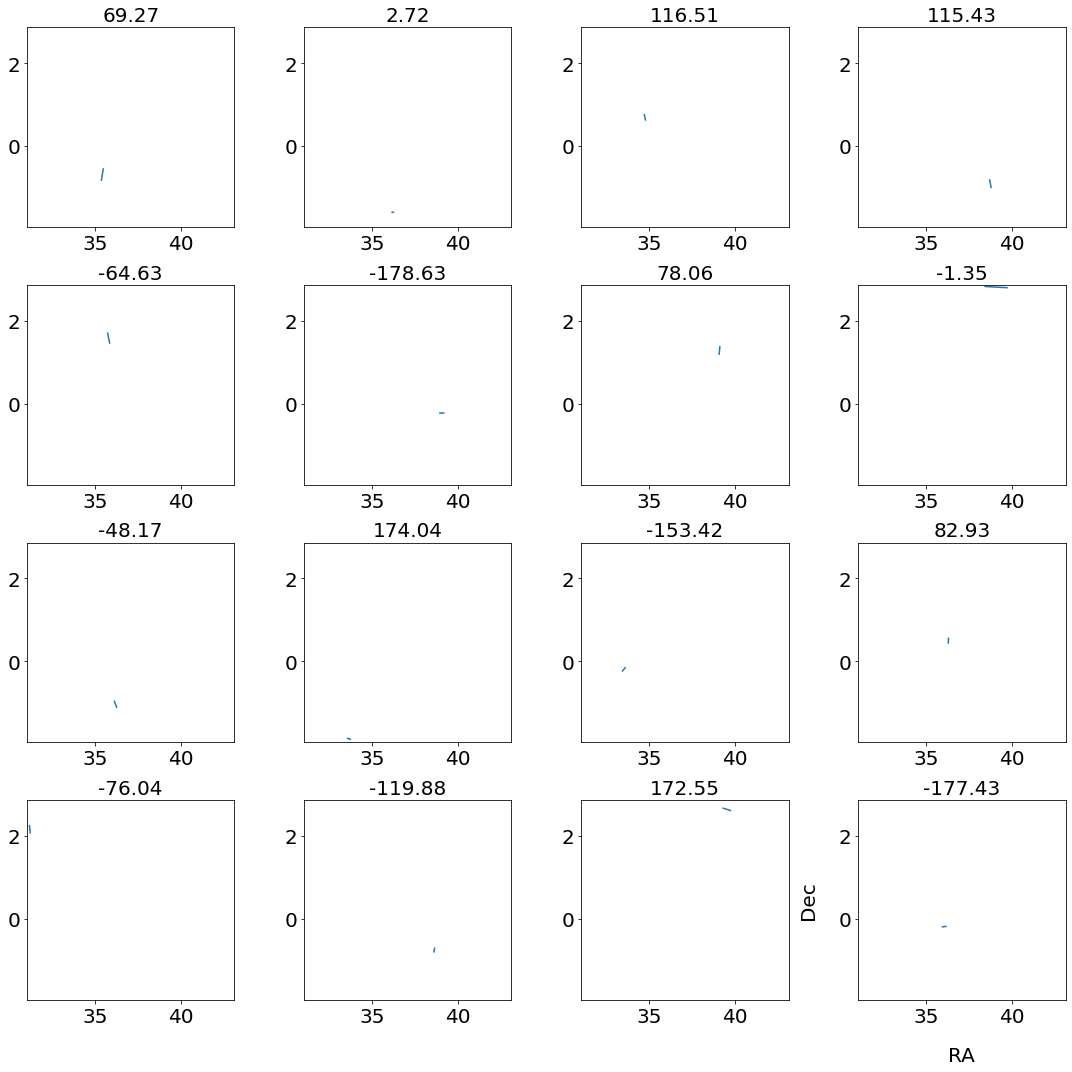

In [146]:
# # Filaments and galaxies projected in RADEC
# c = SkyCoord(x=fila_x_arr, y=fila_y_arr, z=fila_z_arr, unit='Mpc/h', representation_type='cartesian')
# c.representation_type = 'spherical'

# fig = pl.figure(figsize=(15,15))    
# for i, ifs in enumerate(ID_FILA_SEGMENTS[:16]):
#     pl.subplot(4,4,i+1)
#     pl.plot([c.to_table()[ 'ra'][ifs[0]].to_value(), c.to_table()[ 'ra'][ifs[1]].to_value()],
#             [c.to_table()['dec'][ifs[0]].to_value(), c.to_table()['dec'][ifs[1]].to_value()])
#     pl.title(f'{TILT_FILA_SEGMENTS_RADEC[i]*180/np.pi:.2f}')
#     pl.xlim(min(c.to_table()[ 'ra'].to_value()), max(c.to_table()[ 'ra'].to_value()))
#     pl.ylim(min(c.to_table()[ 'dec'].to_value()), max(c.to_table()[ 'dec'].to_value()))
    
# # pl.scatter(data_match[ii_ddp1 & ii_g15 & ii_distance]['RA'],
# #            data_match[ii_ddp1 & ii_g15 & ii_distance]['DEC'], s=5)
# pl.xlabel('RA')
# pl.ylabel('Dec')
# pl.tight_layout()
# pl.show()

In [115]:
# np.arctan2( (1-0),(1-0))*180/np.pi, np.arctan2( (1-0),(-1-0))*180/np.pi, np.arctan2( (-1-0),(-1-0))*180/np.pi, np.arctan2( (-1-0),(1-0))*180/np.pi

(45.0, 135.0, -135.0, -45.0)

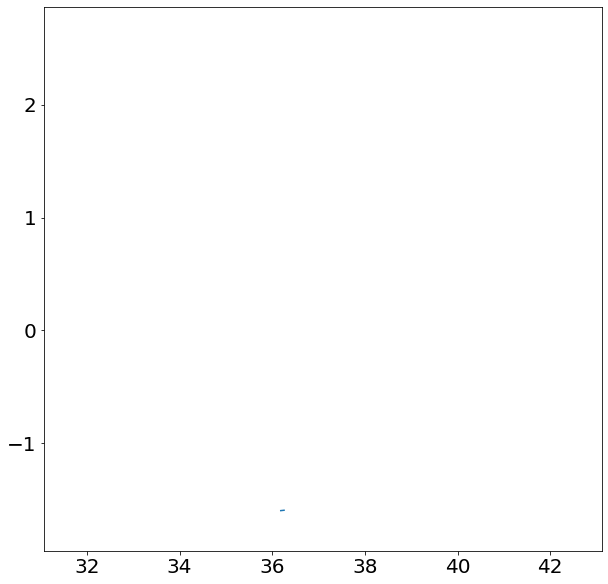

(-1.596112443283722,
 -1.5994849102246884,
 36.25517907068506,
 36.184209617333416,
 2.720647602115019)

In [148]:
ifs_ex = ID_FILA_SEGMENTS[1]
coor_ex = [c.to_table()[ 'ra'][ifs_ex[0]].to_value(), c.to_table()[ 'ra'][ifs_ex[1]].to_value()],[c.to_table()['dec'][ifs_ex[0]].to_value(), c.to_table()['dec'][ifs_ex[1]].to_value()]
pl.plot([c.to_table()[ 'ra'][ifs_ex[0]].to_value(), c.to_table()[ 'ra'][ifs_ex[1]].to_value()],
        [c.to_table()['dec'][ifs_ex[0]].to_value(), c.to_table()['dec'][ifs_ex[1]].to_value()])
pl.xlim(min(c.to_table()[ 'ra'].to_value()), max(c.to_table()[ 'ra'].to_value()))
pl.ylim(min(c.to_table()[ 'dec'].to_value()), max(c.to_table()[ 'dec'].to_value()))
pl.show()
coor_ex[1][1], coor_ex[1][0],coor_ex[0][1],coor_ex[0][0], np.arctan2((coor_ex[1][1]- coor_ex[1][0]),(coor_ex[0][1]-coor_ex[0][0]))*180/np.pi